In [1]:
import os, shutil, json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from numpy import reshape, expand_dims

# VK
import glob
import time
import matplotlib.colors as mcolors

tf.random.set_seed(0) # so that datasets are identically shuffled per iteration for each model

In [2]:
#to get the current working directory
directory = os.getcwd()

print(directory)

D:\Python\jupyter


In [3]:
os.chdir("D:\Git stuff\Tiriamiasis_Projektas_2")

#to get the current working directory
directory = os.getcwd()

print(directory)

D:\Git stuff\Tiriamiasis_Projektas_2


In [51]:
GRID_SIZE = 32
VECTOR_LENGTH = GRID_SIZE * GRID_SIZE
CHANNELS = 1
GRID_STRING = str(GRID_SIZE) + 'x' + str(GRID_SIZE)

if not(os.path.isdir('logs/' + GRID_STRING)):
    os.mkdir('logs/' + GRID_STRING)

In [52]:
# the format of .mat files:
# if, for example, we have 8x8 permeability map, then in the .mat file the first row will represent one map and
# the matrix has been expanded from 2D into 1D in such a way: 1 row + 2 row + 3 row + ... + 8 row.

permeability = loadmat('Data/' + GRID_STRING + '_permeability.mat')
_, perm_norms = normalize(permeability['permeability'], norm = 'l2', axis = 0, return_norm = True)
permeability = pd.DataFrame(permeability['permeability'])

target = loadmat('Data/' + GRID_STRING + '_target.mat')
target = pd.DataFrame((target['target']))

perm_train, perm_test_nonorm, target_train, target_test = train_test_split(permeability, target, test_size = 0.2, 
                                                                                  random_state = 0)

perm_train = perm_train / perm_norms
perm_test = perm_test_nonorm / perm_norms

In [53]:
# palyginimui tiesines regresijos MSE ir MAE

lin_reg = LinearRegression(n_jobs = -1)
lin_reg.fit(perm_train, target_train)

predicted_target = lin_reg.predict(perm_test)
MSE = mean_squared_error(target_test, predicted_target)
MAE = mean_absolute_error(target_test, predicted_target)

print(MSE, MAE)

26.3589435090282 3.8605152944158903


In [7]:
def clear_model_logs(model_name):
    folder = 'logs/' + GRID_STRING + '/' + model_name
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
def save_extra_info(optimizer, batch_size, model, model_name):
    if not(os.path.isdir('logs/'+ GRID_STRING + '/' + model_name)):
        os.mkdir('logs/'+ GRID_STRING + '/' + model_name)
    
    supp_info = tf.keras.optimizers.serialize(optimizer)
    supp_info["batch_size"] = str(batch_size)
    supp_info["data_size"] = str(sqrt(VECTOR_LENGTH))
    supp_info["train_set_size"] = str(perm_train.shape[0])
    supp_info["test_set_size"] = str(perm_test.shape[0])
    supp_info["model"] = model.to_json()
    
    open('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '.json', 'w').write(json.dumps(supp_info, indent = 4))
    
def fit_model(optimizer, batch_size, model, model_name, epochs):
    save_extra_info(optimizer, batch_size, model, model_name)

    history = model.fit(x = perm_train, y = target_train, batch_size = batch_size, epochs = epochs, verbose = 0, 
              validation_data = (perm_test, target_test), shuffle = True)

    history = pd.DataFrame.from_dict(history.history)
    history.to_csv('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '.csv', index = False)
    model.save('logs/'+ GRID_STRING + '/' + model_name, save_format = "tf")
    
def load_model(model_name, optimizer):
    model = tf.keras.models.load_model(filepath = 'logs/'+ GRID_STRING + '/' + model_name, compile = False)
    model.compile(optimizer = optimizer, loss='mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def FF1(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error']) 
    return model

def FF2(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def FF3(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error']) 
    return model

def FF4(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def FF5(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation = 'linear', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(32, activation = 'linear'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN1(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN2(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN3(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN4(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape = (GRID_SIZE, 
                                                                                                            GRID_SIZE, 
                                                                                                            CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN5(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN6(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN7(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN8(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN9(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN10(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN11(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN12(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN13(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN14(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN15(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

def CNN16(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same', 
                                     input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(.4))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(.2))
    model.add(tf.keras.layers.Dense(256, activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mean_absolute_error', 'mean_squared_error'])
    return model

In [126]:
# launch model experiments

batch_size = 100
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model_name = 'CNN16'
# if we want to continue fitting an existing model
#model = load_model('FF1', optimizer)
model = CNN16(optimizer)
model.summary()


t = time.time()

fit_model(optimizer, batch_size, model, model_name, epochs = 250)

elapsed = time.time() - t
print(elapsed)

#      | 8x8 5000 epoch | 64 250 epoch
#CNN6  | 163s           |
#CNN5  | 164s           | 204s
#CNN7  | 184s           |
#CNN13 | 396s           | 673s
#CNN14 | 
#CNN15 |                | 1141s


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_33 (Reshape)        (None, 64, 64, 1)         0         
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 128)       1280      
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 7, 7, 256)        0         
 g2D)                                                

0.1630204766988754 1.7399784326553345
0.2006908357143402 0.7558656334877014


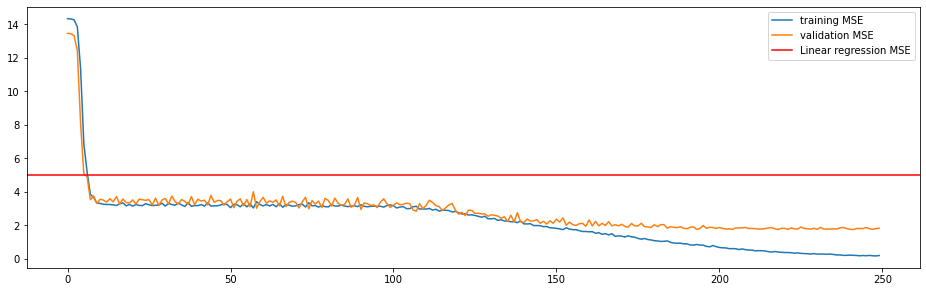

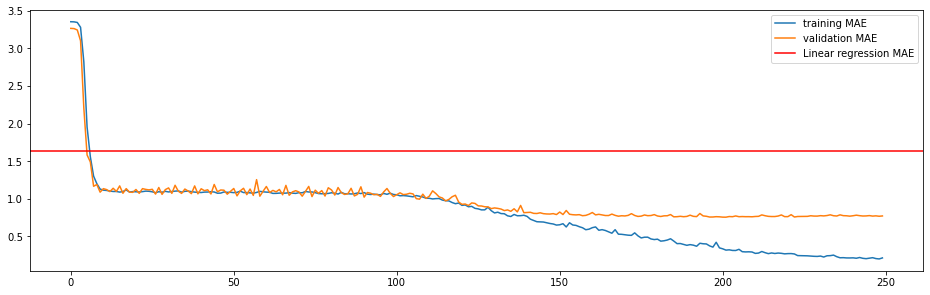

In [127]:
#model_name = 'CNN6'

history = pd.read_csv('logs/' + GRID_STRING + '/' + model_name + '/' + model_name + '.csv')

plt.figure(figsize = (16, 4.8))
plt.plot(history["mean_squared_error"], label = "training MSE")
plt.plot(history["val_mean_squared_error"], label = "validation MSE")
plt.axhline(y = MSE, color = 'r', linestyle = '-', label = 'Linear regression MSE')
plt.legend(loc = 'upper right')
print("{:.16f}".format(min(history["mean_squared_error"])), min(history["val_mean_squared_error"]))


plt.figure(figsize = (16, 4.8))
plt.plot(history["mean_absolute_error"], label = "training MAE")
plt.plot(history["val_mean_absolute_error"], label = "validation MAE")
plt.axhline(y = MAE, color = 'r', linestyle = '-', label = 'Linear regression MAE')
plt.legend(loc = 'upper right')
print(min(history["mean_absolute_error"]), min(history["val_mean_absolute_error"]))

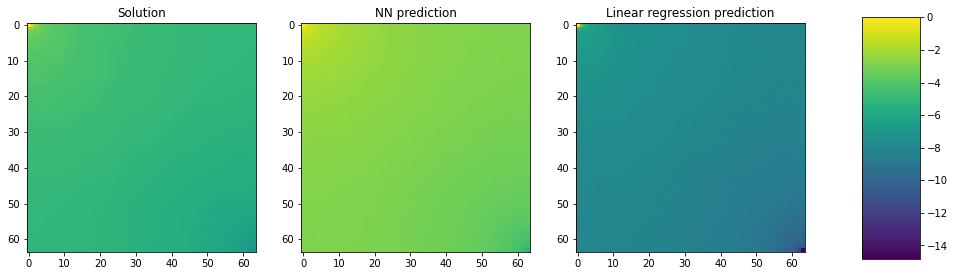

In [128]:
map_index = 1

dummy_rate = 0.0001
dummy_optimizer = tf.keras.optimizers.Adam(learning_rate = dummy_rate)
model = load_model(model_name, dummy_optimizer)

perm_test_sample = perm_test.iloc[map_index].to_numpy()

test_prediction = model.predict(expand_dims(perm_test_sample, 0), batch_size = 1)
test_prediction = reshape(test_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

lin_reg_prediction = lin_reg.predict(perm_test_sample.reshape(1, -1))
lin_reg_prediction = reshape(lin_reg_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

test_solution = reshape(target_test.iloc[map_index].to_numpy(), (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

cm_range = [min(min(test_solution.flatten()), min(test_prediction.flatten()), min(lin_reg_prediction.flatten())), 
            max(max(test_solution.flatten()), max(test_prediction.flatten()), max(lin_reg_prediction.flatten()))]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4.8))
im = axes[0].imshow(test_solution, vmin = cm_range[0], vmax = cm_range[1])
axes[0].title.set_text('Solution')
im = axes[1].imshow(test_prediction, vmin = cm_range[0], vmax = cm_range[1])
axes[1].title.set_text('NN prediction')
im = axes[2].imshow(lin_reg_prediction, vmin = cm_range[0], vmax = cm_range[1])
axes[2].title.set_text('Linear regression prediction')

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

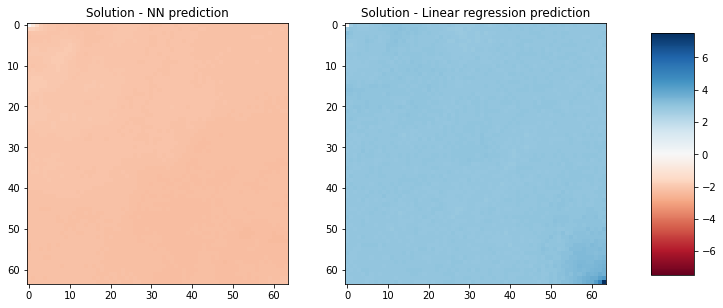

In [129]:
# Difference heatmap
sol_pred_difference = test_solution - test_prediction
sol_linpred_difference = test_solution - lin_reg_prediction

cm_range = [min(min(sol_pred_difference.flatten()), min(sol_linpred_difference.flatten())), 
            max(max(sol_pred_difference.flatten()), max(sol_linpred_difference.flatten()))]

vmax = max(map(abs, cm_range))

norm = mcolors.TwoSlopeNorm(vmin = -vmax, vmax = vmax, vcenter = 0)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.8))
im = axes[0].imshow(sol_pred_difference, cmap = plt.cm.RdBu, norm = norm)
axes[0].title.set_text('Solution - NN prediction')
im = axes[1].imshow(sol_linpred_difference, cmap = plt.cm.RdBu, norm = norm)
axes[1].title.set_text('Solution - Linear regression prediction')

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [49]:
# Read last metric of all models insider logs directory

history_files = glob.glob('logs/' + GRID_STRING + '/' + '/**/*.csv', recursive = True)

model_metrics = pd.DataFrame(columns = ['epochs', 'model_name', 'loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
                                        'val_mean_absolute_error', 'val_mean_squared_error'])
model_history = model_metrics

for i in range(0, len(history_files)):
    model_name = os.path.basename(history_files[i])
    history = pd.read_csv(history_files[i])
    history = history.assign(model_name = os.path.splitext(model_name)[0])
    history = history.rename_axis("epochs").reset_index()
    history.epochs = history.epochs + 1
    model_history = pd.concat([model_history, history], ignore_index = True)
    model_metrics = pd.concat([model_metrics, history.tail(1)], ignore_index = True)

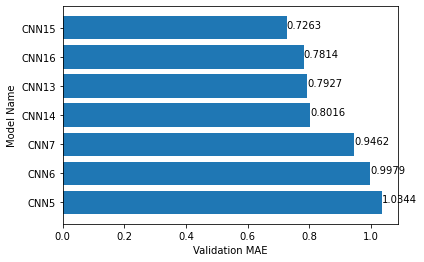

In [50]:
df_sorted = model_metrics.sort_values('val_mean_absolute_error', ascending = False)

# Plot horizontal bar chart
bars = plt.barh('model_name', 'val_mean_absolute_error', data = df_sorted)

# To get data labels
for  bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    plt.text(width, label_y, s=f'{width:.4f}')
    
# Define axes labels
plt.xlabel("Validation MAE")
plt.ylabel("Model Name")

# Display a bar chart
plt.show()

#CNN6 | CNN5 | CNN7 | CNN13 | CNN14

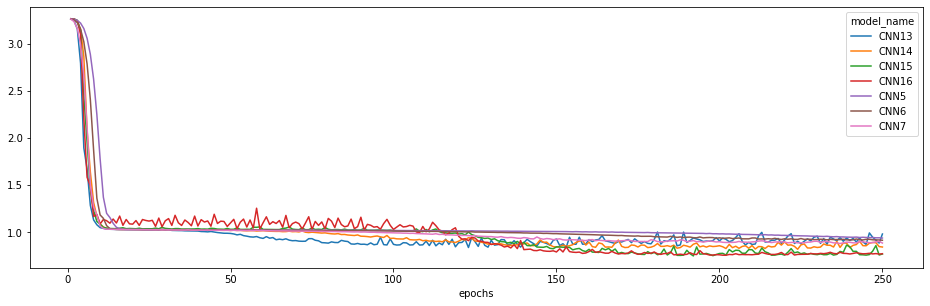

In [10]:
df_pivot = model_history.pivot(index = 'epochs', columns = 'model_name', values = 'val_mean_absolute_error')

df_pivot.plot(figsize=(16, 4.8))
plt.show()

In [3]:
# upload logs to jupyter

#import zipfile as zf
#files = zf.ZipFile("C:/Users/viliu/Downloads/logs/8x8.zip", 'r')
#files.extractall("logs/")
#files.close()

In [151]:
model = load_model('CNN6', dummy_optimizer)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 28224)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               3612800   
                                                                 
 dense_17 (Dense)            (None, 4096)              528384    
                                                      

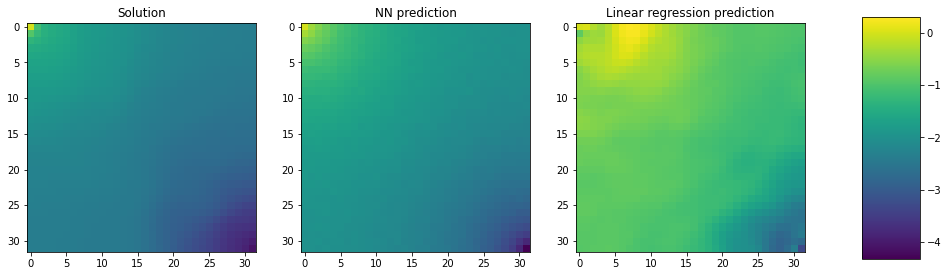

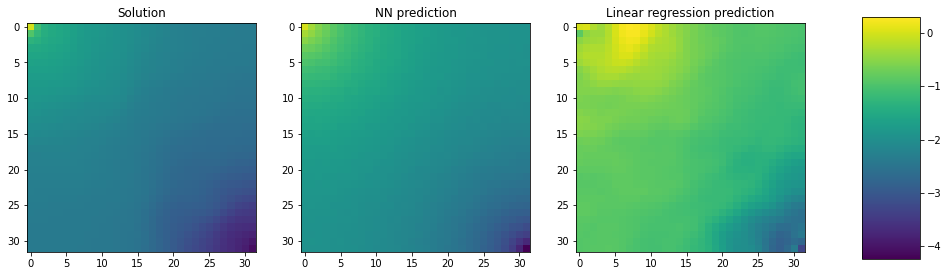

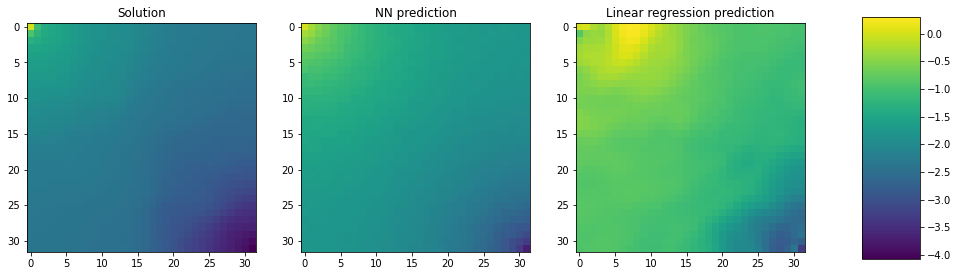

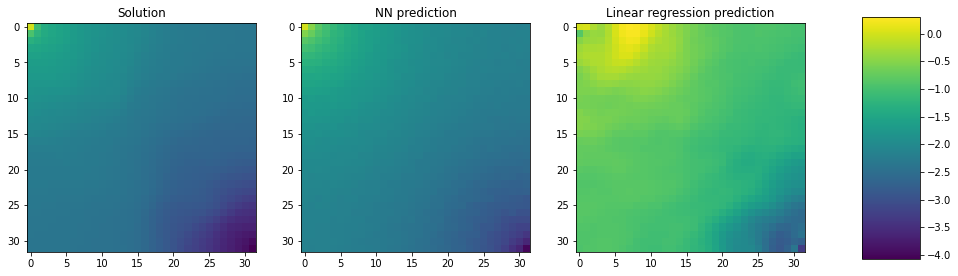

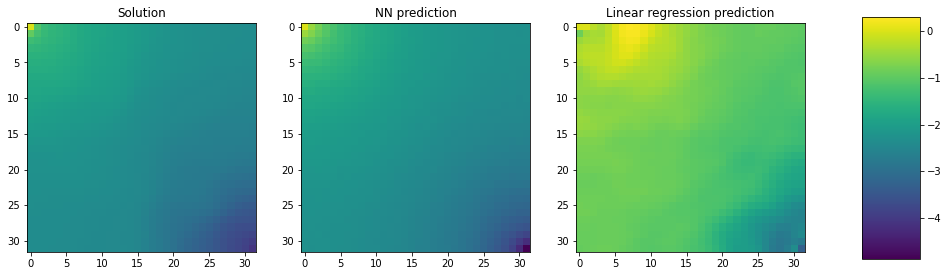

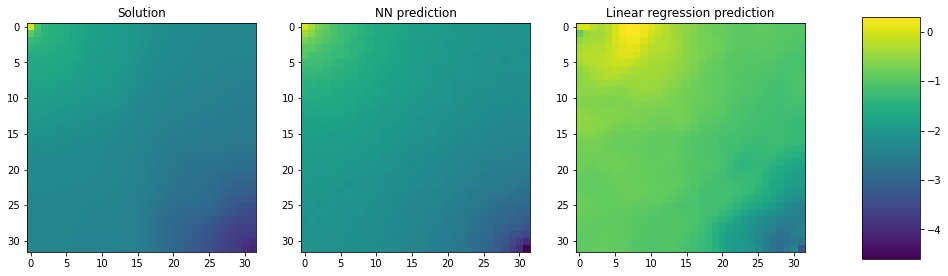

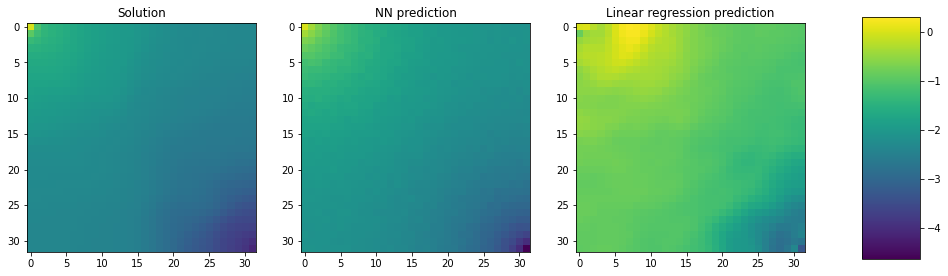

In [54]:
# Save Solution vs NN prediction vs LR prediction png files for all models

map_index = 1

dummy_rate = 0.0001
dummy_optimizer = tf.keras.optimizers.Adam(learning_rate = dummy_rate)

history_files = glob.glob('logs/' + GRID_STRING + '/' + '/**/*.csv', recursive = True)

for i in range(0, len(history_files)):
    model_name = os.path.splitext(os.path.basename(history_files[i]))[0]
    model = load_model(model_name, dummy_optimizer)
    perm_test_sample = perm_test.iloc[map_index].to_numpy()
    perm_test_nonorm_sample = perm_test_nonorm.iloc[map_index].to_numpy()

    test_prediction = model.predict(expand_dims(perm_test_sample, 0), batch_size = 1)
    test_prediction = reshape(test_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

    lin_reg_prediction = lin_reg.predict(perm_test_sample.reshape(1, -1))
    lin_reg_prediction = reshape(lin_reg_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

    test_solution = reshape(target_test.iloc[map_index].to_numpy(), (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

    cm_range = [min(min(test_solution.flatten()), min(test_prediction.flatten()), min(lin_reg_prediction.flatten())), 
                max(max(test_solution.flatten()), max(test_prediction.flatten()), max(lin_reg_prediction.flatten()))]

    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4.8))
    im = axes[0].imshow(test_solution, vmin = cm_range[0], vmax = cm_range[1])
    axes[0].title.set_text('Solution')
    im = axes[1].imshow(test_prediction, vmin = cm_range[0], vmax = cm_range[1])
    axes[1].title.set_text('NN prediction')
    im = axes[2].imshow(lin_reg_prediction, vmin = cm_range[0], vmax = cm_range[1])
    axes[2].title.set_text('Linear regression prediction')

    fig.subplots_adjust(right = 0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.savefig('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- Solution_NN_LR.png')
    savemat('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- Solution.mat', mdict={'test_solution': test_solution})
    savemat('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- NN.mat', mdict={'test_prediction': test_prediction})
    savemat('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- LR.mat', mdict={'lin_reg_prediction': lin_reg_prediction})
    savemat('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- Permeability.mat', mdict={'perm_test_nonorm_sample': perm_test_nonorm_sample})

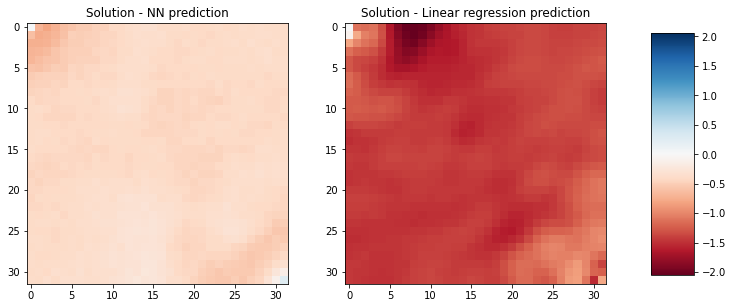

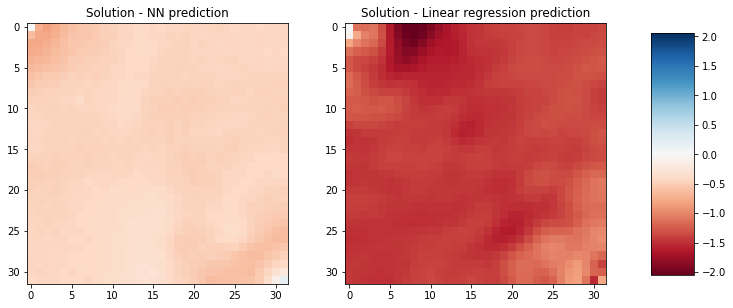

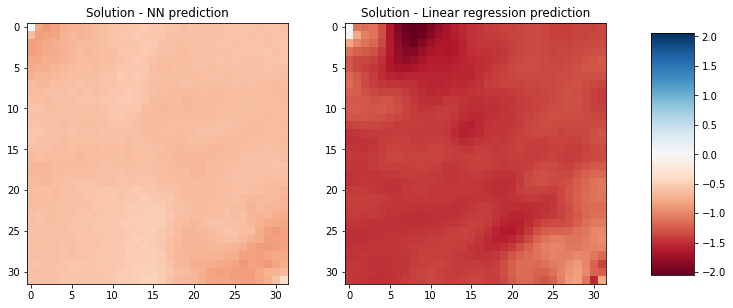

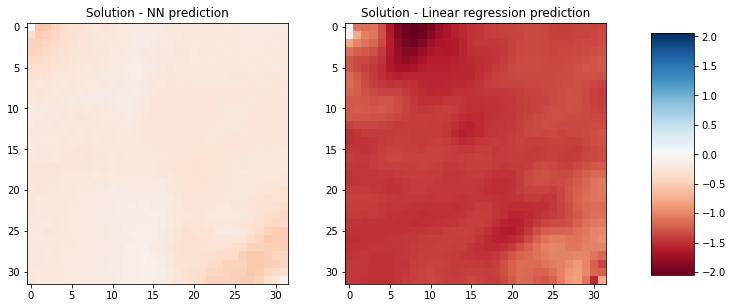

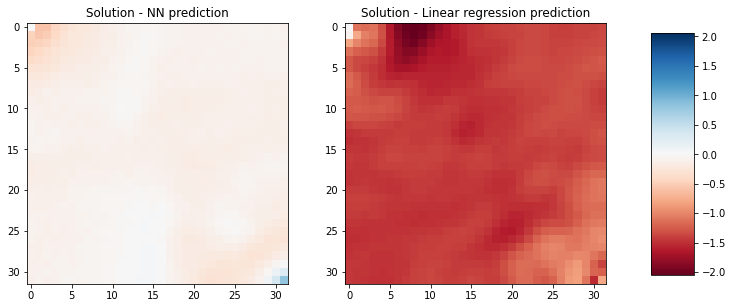

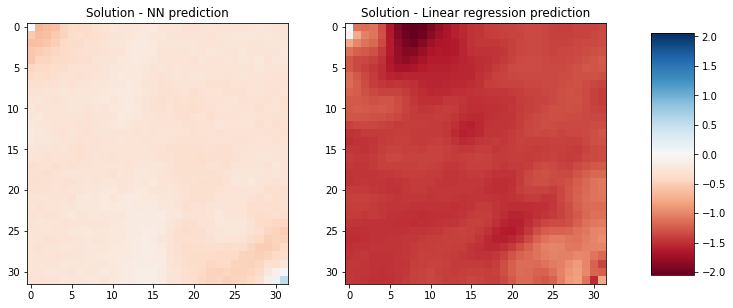

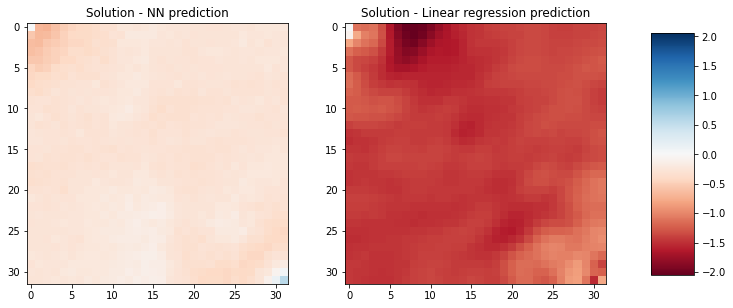

In [48]:
# Save difference heatmap png files for all models

for i in range(0, len(history_files)):
    model_name = os.path.splitext(os.path.basename(history_files[i]))[0]
    model = load_model(model_name, dummy_optimizer)
    
    perm_test_sample = perm_test.iloc[map_index].to_numpy()

    test_prediction = model.predict(expand_dims(perm_test_sample, 0), batch_size = 1)
    test_prediction = reshape(test_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

    lin_reg_prediction = lin_reg.predict(perm_test_sample.reshape(1, -1))
    lin_reg_prediction = reshape(lin_reg_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

    test_solution = reshape(target_test.iloc[map_index].to_numpy(), (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))
    
    # Difference heatmap
    sol_pred_difference = test_solution - test_prediction
    sol_linpred_difference = test_solution - lin_reg_prediction
    
    cm_range = [min(min(sol_pred_difference.flatten()), min(sol_linpred_difference.flatten())), 
                max(max(sol_pred_difference.flatten()), max(sol_linpred_difference.flatten()))]

    vmax = max(map(abs, cm_range))

    norm = mcolors.TwoSlopeNorm(vmin = -vmax, vmax = vmax, vcenter = 0)

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4.8))
    im = axes[0].imshow(sol_pred_difference, cmap = plt.cm.RdBu, norm = norm)
    axes[0].title.set_text('Solution - NN prediction')
    im = axes[1].imshow(sol_linpred_difference, cmap = plt.cm.RdBu, norm = norm)
    axes[1].title.set_text('Solution - Linear regression prediction')

    fig.subplots_adjust(right = 0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.savefig('logs/'+ GRID_STRING + '/' + model_name + '/' + model_name + '- Heatmap.png')